In [108]:
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure import plotter
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import integrate

In [109]:
mp_key = "kUNltwLCR9AdLypQdV0AJRVJ3G9Yb7B8"
mp_id = "mp-8426"

In [110]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Calcul de $\theta_E$ et $\theta_D$

In [111]:
# Valeurs issues du notebook d'exemple

temperatures = np.arange(0,1000,5)
R = 8.314
nat = len(prim_struc)
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))])/(3*nat*R)



L'équation de la chaleur spécifique molaire selon le modèle de Einstein:
\begin{equation}
    Cv_{\text{Einst}}/3 N_\text{at} R= \frac{\left( \frac{\theta_E}{T} \right)^2 e^{\frac{\theta_E}{T}}}{(e^{\frac{\theta_E}{T}} - 1)^2}
\end{equation} L'équation de la chaleur spécifique molaire selon le modèle de Debye:
\begin{equation}
    Cv_{\text{Debye}}/3 N_\text{at} R = 3 \left( \frac{T}{\theta_D} \right)^3 \int_{0}^{\frac{\theta_D}{T}} \frac{x^4 e^x}{(e^x - 1)^2} \, dx
\end{equation}



In [112]:
def Cv_E(Theta_E, T) :
    return ((Theta_E/T)**2 * np.exp(Theta_E/T)) / ((np.exp(Theta_E/T) - 1)**2)


def fct(x):
    return (x**4)*np.exp(x) / ((np.exp(x)-1)**2)

def Cv_D(Theta_D, T):
    return 3*((T/Theta_D)**3)*integrate.quad(fct, 0, Theta_D/T)[0]


def sq_error(x,y) :
    return (x-y)**2



error_min_E = 0
Theta_E = 1
error_min_D = 0
Theta_D = 1

for i in range(1,1000) :
    err_E = 0
    err_D = 0
    for j in range(1,200) :
        Cv_E_pred = Cv_E(i,temperatures[j])
        Cv_D_pred = Cv_D(i,temperatures[j])
        
        err_E += sq_error(Cv_E_pred,ph_cv[j])
        err_D += sq_error(Cv_D_pred,ph_cv[j])
        
    if(i==1) :
        error_min_E = err_E
        error_min_D = err_D
            
    if(err_E < error_min_E) :
        error_min_E = err_E
        Theta_E = i
    if(err_D < error_min_D) :
        error_min_D = err_D
        Theta_D = i
    
print("Temperature d'Einstein = ", Theta_E, "°K")
print("Temperature de Debye = ", Theta_D, "°K")    

Temperature d'Einstein =  144 °K
Temperature de Debye =  194 °K


Conformément à la théorie, la température de Debye est bien suppérieure à celle d'Einstein.

## Représentation des courbes de chaleur spécifique

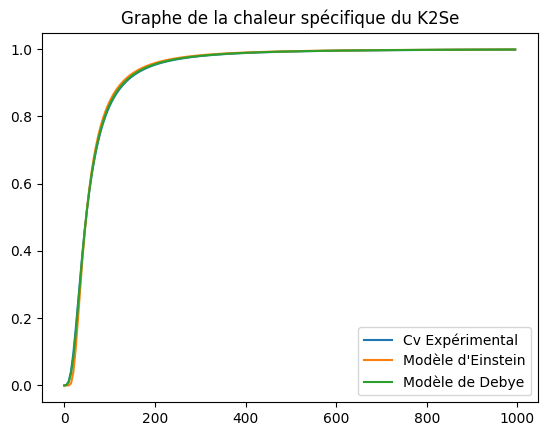

In [113]:
Cv_E_array = [temperatures[0]]
Cv_D_array = [temperatures[0]]

for i in range(1,200) :
    Cv_E_array.append(Cv_E(Theta_E,temperatures[i]))
    Cv_D_array.append(Cv_D(Theta_D,temperatures[i]))



plt.plot(temperatures, ph_cv, label="Cv Expérimental")
plt.plot(temperatures, Cv_E_array, label="Modèle d'Einstein")
plt.plot(temperatures, Cv_D_array, label="Modèle de Debye")

plt.title('Graphe de la chaleur spécifique du K2Se')

plt.legend()

plt.show()

Les deux modèles semblent extrêmement bien suivre la courbe de Cv expérimental.

## Représentation des densités d'états de phonons correspondantes

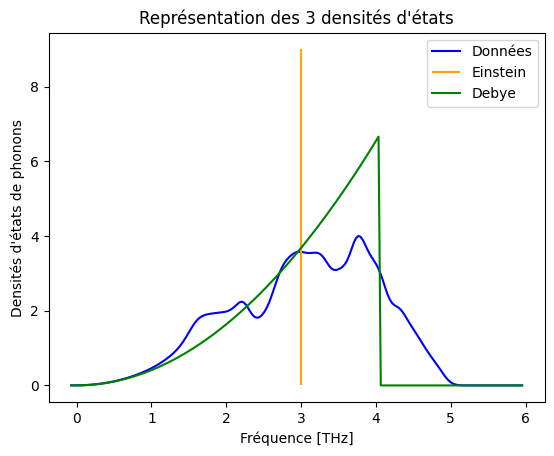

Fréquence d'Einstein =  2.9992553815718526 THz
Pulsation de Debye =  4.040663500173189 THz


In [114]:
k_B = 1.380649e-23
conv_THz = 1e-12
h_bar = 1.055e-34

freq = ph_dos.frequencies 
dens = ph_dos.densities

w_E = conv_THz*k_B*Theta_E/h_bar
freq_E = w_E/(2*np.pi)

w_D = conv_THz*k_B*Theta_D /h_bar

dens_D = np.zeros(len(freq))
for i,f in enumerate(freq):
    w = 2*np.pi*f
    if w < w_D:
        dens_D[i] = (9*nat*(w)**2/(w_D**3))

plt.plot(freq, dens,color="blue", label="Données")
plt.vlines(freq_E, 0, 3 * nat ,color="orange", label = "Einstein")
plt.plot(freq, dens_D*(2*np.pi), color='green', label="Debye")
plt.title("Représentation des 3 densités d'états")
plt.ylabel("Densités d'états de phonons")
plt.xlabel("Fréquence [THz]")
plt.legend()
plt.show()


print("Fréquence d'Einstein = ", freq_E, "THz")
print("Pulsation de Debye = ", w_D/(2*np.pi), "THz")